____
### Mounting Google Drive and Importing Dependencies
___
We mount Google Drive to access datasets and save results. Required libraries for data processing, modeling, and evaluation are also imported. A random seed is set for reproducibility, and warnings are suppressed for cleaner output.
____

In [1]:
from google.colab import drive
import pandas as pd

# 1. Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Data Preprocessing & Feature Selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

# Dimensionality Reduction
from sklearn.decomposition import PCA
import umap
import umap.umap_ as umap  # If needed for specific functionality

# Train/Test Splitting & Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    brier_score_loss,
    matthews_corrcoef
)
from sklearn.calibration import calibration_curve

Load Fluxomics Dataset

The fluxomics dataset is loaded from Google Drive. The shape of the dataset is displayed to confirm successful loading.

In [4]:
# Load dataset
flux_df = pd.read_csv('/content/drive/MyDrive/fluxomics.csv')
print(f"Flux data shape: {flux_df.shape}")
flux_df.info()

Flux data shape: (58177, 403)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58177 entries, 0 to 58176
Columns: 403 entries, PYRt2 to sample_id
dtypes: float64(400), object(3)
memory usage: 178.9+ MB


Prepare Response Labels

The categorical response variable (Responder / Non-responder) is mapped into a binary format (1 and 0). This prepares the dataset for machine learning.

In [5]:
# Convert categorical response into binary
flux_df['response'] = flux_df['response'].map({'Responder': 1, 'Non-responder': 0})

# Separate features and labels
X_flux = flux_df.drop(columns=['barcode', 'response', 'sample_id'], errors='ignore')
y_flux = flux_df['response'].astype(int)

print("Unique response values:", y_flux.unique())

Unique response values: [1 0]


Load Gene Expression Dataset

A processed gene expression dataset is loaded. We select only numeric features for further preprocessing.

In [6]:
gene_df_renamed = pd.read_csv("/content/drive/MyDrive/MultimodalCSVs/gene_df_processed.csv")
print("Gene DataFrame shape:", gene_df_renamed.shape)

# Extract numeric gene expression features
X_gene = gene_df_renamed.drop(columns=['response', 'response_binary', 'sample_id'], errors='ignore') \
                        .select_dtypes(include=[np.number])
gene_cols_original = X_gene.columns.tolist()

Gene DataFrame shape: (58177, 2003)


Scale and Variance Thresholding

Both gene and fluxomics features are standardized using StandardScaler, and low-variance features are removed with VarianceThreshold. This step improves model robustness by eliminating non-informative variables.

In [7]:
# Scale and filter gene features
scaler_gene = StandardScaler()
X_gene_scaled = scaler_gene.fit_transform(X_gene)
selector_gene = VarianceThreshold(threshold=1e-4)
X_gene_var = selector_gene.fit_transform(X_gene_scaled)
gene_cols = [gene_cols_original[i] for i in selector_gene.get_support(indices=True)]

# Scale and filter flux features
scaler_flux = StandardScaler()
X_flux_scaled = scaler_flux.fit_transform(X_flux)
selector_flux = VarianceThreshold(threshold=1e-4)
X_flux_var = selector_flux.fit_transform(X_flux_scaled)
flux_cols = [X_flux.columns[i] for i in selector_flux.get_support(indices=True)]

print("Gene features shape:", X_gene_var.shape)
print("Flux features shape:", X_flux_var.shape)

Gene features shape: (58177, 2000)
Flux features shape: (58177, 255)


Combine Gene and Flux Features

We concatenate the filtered features into a single dataset, preserving response_binary and sample_id for later supervised learning and patient-wise stratification.

In [8]:
combined_features = np.concatenate([X_gene_var, X_flux_var], axis=1)
combined_cols = gene_cols + flux_cols
combined_df = pd.DataFrame(combined_features, columns=combined_cols)

# Add response and sample_id
combined_df['response_binary'] = gene_df_renamed['response_binary'].values
combined_df['sample_id'] = gene_df_renamed['sample_id'].values

print("Combined DataFrame shape:", combined_df.shape)

Combined DataFrame shape: (58177, 2257)


In [9]:
# Step 1: Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Create folder if it doesn't exist
import os
folder_path = "/content/drive/MyDrive/MultimodalCSVs"
os.makedirs(folder_path, exist_ok=True)

# Step 3: Define save path
save_path = os.path.join(folder_path, "gene_flux_multimodal.csv")

# Step 4: Save combined DataFrame as CSV
combined_df.to_csv(save_path, index=False)

#print(f"Combined DataFrame saved to: {save_path}")
#print("Shape:", combined_df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#Define the file path
file_path = "/content/drive/MyDrive/MultimodalCSVs/gene_flux_multimodal.csv"

# Load the CSV into memory
multimodal_df = pd.read_csv(file_path)

print("Loaded DataFrame shape:", multimodal_df.shape)
print("Columns:", multimodal_df.columns[:10])  # preview first 10 columns

Loaded DataFrame shape: (58177, 2257)
Columns: Index(['ENSG00000272512', 'LINC01786', 'CALML6', 'CFAP74', 'GABRD',
       'ENSG00000287727', 'ENSG00000287384', 'FBLIM1', 'ENSG00000236936',
       'C1QA'],
      dtype='object')


In [11]:
multimodal_df.head()

,ENSG00000272512,LINC01786,CALML6,CFAP74,GABRD,ENSG00000287727,ENSG00000287384,FBLIM1,ENSG00000236936,C1QA,...,r0027,HMR_3996,CYSGLTH,Transport_ala_B_c_e,t_Lcystin_ala__L,t_Lcystin_glu__L,t_Lcystin_leu__L,t_Lcystin_ser__L,response_binary,sample_id
0,-0.013603,-0.010721,-0.010086,-0.008178,-0.01729,-0.023815,-0.00749,-0.005667,-0.039642,-0.091401,...,-0.417258,0.838937,-0.655739,-0.297115,-0.691497,0.790849,-0.100524,-0.356965,1,GSM9061665_S1
1,-0.013603,-0.010721,-0.010086,-0.008178,-0.01729,-0.023815,-0.00749,-0.005667,-0.039642,-0.091401,...,-0.417258,0.884267,-0.655739,-0.297115,-0.691497,0.837554,-0.100524,-0.356965,1,GSM9061665_S1
2,-0.013603,-0.010721,-0.010086,-0.008178,-0.01729,-0.023815,-0.00749,-0.005667,-0.039642,-0.091401,...,-0.417258,1.058648,-0.655739,-0.297115,-0.691497,1.017221,-0.100524,-0.356965,1,GSM9061665_S1
3,-0.013603,-0.010721,-0.010086,-0.008178,-0.01729,-0.023815,-0.00749,-0.005667,-0.039642,-0.091401,...,-0.417258,0.866741,-0.655739,-0.297115,0.008473,0.194323,-0.100524,-0.356965,1,GSM9061665_S1
4,-0.013603,-0.010721,-0.010086,-0.008178,-0.01729,-0.023815,-0.00749,-0.005667,-0.039642,-0.091401,...,2.287480,-0.561103,-0.655739,-0.297115,-0.691497,1.016068,-0.100524,-0.071392,1,GSM9061665_S1


In [12]:
multimodal_df.shape

(58177, 2257)

In [13]:
duplicate_count = multimodal_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [14]:
multimodal_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58177 entries, 0 to 58176
Data columns (total 2257 columns):
 #     Column                   Non-Null Count  Dtype  
---    ------                   --------------  -----  
 0     ENSG00000272512          58177 non-null  float64
 1     LINC01786                58177 non-null  float64
 2     CALML6                   58177 non-null  float64
 3     CFAP74                   58177 non-null  float64
 4     GABRD                    58177 non-null  float64
 5     ENSG00000287727          58177 non-null  float64
 6     ENSG00000287384          58177 non-null  float64
 7     FBLIM1                   58177 non-null  float64
 8     ENSG00000236936          58177 non-null  float64
 9     C1QA                     58177 non-null  float64
 10    C1QC                     58177 non-null  float64
 11    C1QB                     58177 non-null  float64
 12    LINC01355                58177 non-null  float64
 13    ENSG00000271420          58177 non-null  f

In [15]:
print(multimodal_df.isnull().sum())

ENSG00000272512     0
LINC01786           0
CALML6              0
CFAP74              0
GABRD               0
                   ..
t_Lcystin_glu__L    0
t_Lcystin_leu__L    0
t_Lcystin_ser__L    0
response_binary     0
sample_id           0
Length: 2257, dtype: int64


In [16]:
non_feature_cols = ['response_binary', 'sample_id']
X = multimodal_df.drop(columns=non_feature_cols)
y = multimodal_df['response_binary']

patients = combined_df['sample_id'].unique()
train_patients, test_patients = train_test_split(
    patients,
    test_size=0.2,
    random_state=42,
    stratify=combined_df.groupby('sample_id')['response_binary'].first()
)

train_mask = combined_df['sample_id'].isin(train_patients)
test_mask = combined_df['sample_id'].isin(test_patients)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")
print("Train distribution:", y_train.value_counts(normalize=True))
print("Test distribution:", y_test.value_counts(normalize=True))

Train set: (43785, 2255), Test set: (14392, 2255)
Train distribution: response_binary
0    0.627978
1    0.372022
Name: proportion, dtype: float64
Test distribution: response_binary
0    0.797665
1    0.202335
Name: proportion, dtype: float64


Random Forest and Top Feature Selection

We train a Random Forest model to estimate feature importance, then keep the top 100 predictive features.

In [17]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Get top 100 features
top100_indices = np.argsort(rf.feature_importances_)[::-1][:100]
top100_features = X_train.columns[top100_indices]

# Overwrite X_train and X_test so LR runs smoothly
X_train = X_train[top100_features]
X_test = X_test[top100_features]

print("Top 100 features shape:", X_train.shape)

Top 100 features shape: (43785, 100)


# **Logistic Regression**

Best Parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}

[Responder Class Metrics]
Accuracy     : 88.54
Precision    : 70.96
Recall       : 73.35
F1 Score     : 72.14
ROC AUC Score: 90.13


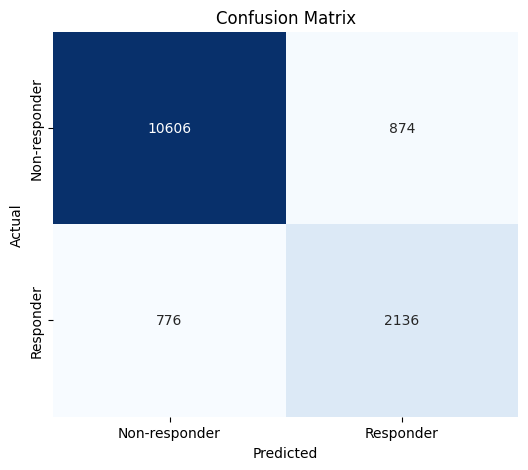

In [18]:
# Step 1: Define pipeline (scaling + logistic regression)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    ))
])

# Step 2: Smaller parameter grid for faster search
param_grid = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1','l2']
}

# Step 3: Run GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,              # fewer folds to speed up
    scoring='roc_auc', # still optimizes AUC
    n_jobs=-1
)
grid.fit(X_train, y_train)

# Step 4: Best model
logreg = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Step 5: Predictions
y_prob = logreg.predict_proba(X_test)[:, 1]
y_pred_thresh = logreg.predict(X_test)

# Step 6: Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_thresh)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred_thresh)
recall = recall_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)
accuracy = accuracy_score(y_test, y_pred_thresh)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Step 7: Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **XGBoost**

scale_pos_weight: 1.69
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:24:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 800}

Classification Report (Test Data):
               precision    recall  f1-score   support

Non-responder       0.91      0.95      0.93     11480
    Responder       0.77      0.61      0.68      2912

     accuracy                           0.88     14392
    macro avg       0.84      0.78      0.81     14392
 weighted avg       0.88      0.88      0.88     14392


[Responder Class Metrics]
Accuracy     : 88.43
Precision    : 76.82
Recall       : 61.33
F1 Score     : 68.21
ROC AUC Score: 93.08


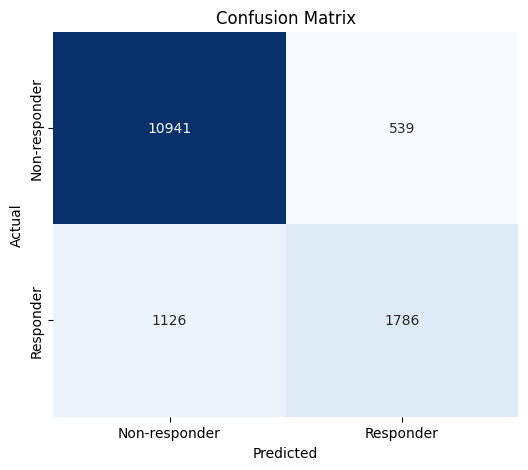

In [19]:
# Step 1: Compute class weights to address imbalance
neg = (y_train == 0).sum()  # Non-responders
pos = (y_train == 1).sum()  # Responders
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Step 2: Define pipeline (XGBoost only, no scaler needed)
pipe_xgb = Pipeline([
    ('model', XGBClassifier(
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist',
        random_state=42
    ))
])

# Step 3: Parameter grid (same as original)
param_xgb = {
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [200, 400, 800]
}

# Step 4: GridSearchCV with 3-fold CV
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_xgb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Step 5: Fit
grid_xgb.fit(X_train, y_train)

# Step 6: Best model
best_xgb = grid_xgb.best_estimator_
print("\nBest Parameters:", grid_xgb.best_params_)

# Step 7: Predictions
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Step 8: Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Step 8b: Classification Report
print("\nClassification Report (Test Data):")
print(classification_report(
    y_test,
    y_pred,
    target_names=['Non-responder', 'Responder']
))

# Step 9: Print metrics
print("\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Step 10: Confusion Matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Feature Importance**

/tmp/ipython-input-781515456.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='viridis')


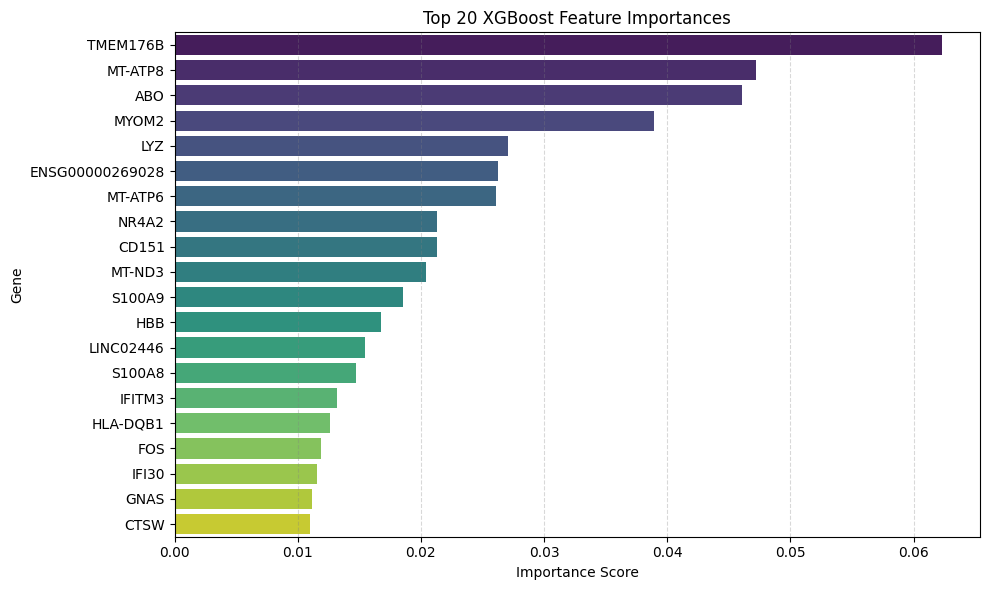

In [20]:
# Access the fitted XGBClassifier inside the pipeline
fitted_xgb = best_xgb.named_steps['model']

# Get feature importances
importances = fitted_xgb.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = importances.argsort()[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]

# Select top N (e.g., 20)
top_n = 20
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')

plt.title(f"Top {top_n} XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Gene")
plt.grid(True, axis='x', linestyle='--', alpha=0.3, color='gray')
plt.tight_layout()
plt.show()

# **Random Forest**

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'model__min_samples_leaf': 50}

[Responder Class Metrics]
Accuracy     : 90.08
Precision    : 79.54
Recall       : 68.61
F1 Score     : 73.67
ROC AUC Score: 94.81

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     11480
           1       0.80      0.69      0.74      2912

    accuracy                           0.90     14392
   macro avg       0.86      0.82      0.84     14392
weighted avg       0.90      0.90      0.90     14392



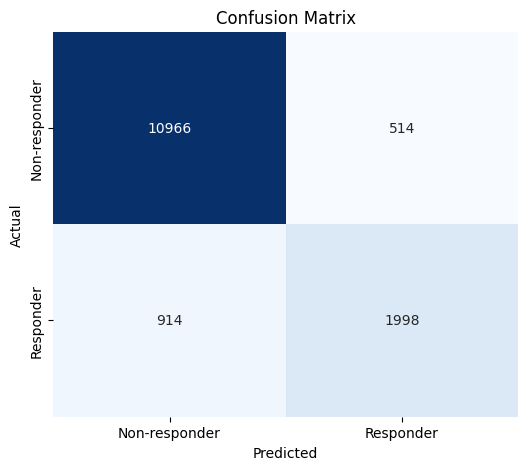

In [21]:
# Step 1: Define pipeline (RF only)
pipe_rf = Pipeline([
    ('model', RandomForestClassifier(
        n_estimators=500,
        max_features='sqrt',
        max_depth=8,
        min_samples_split=100,
        class_weight='balanced',
        random_state=42
    ))
])

# Step 2: Parameter grid
param_rf = {
    'model__min_samples_leaf': [50, 100]
}

# Step 3: GridSearchCV with 3-fold CV
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_rf,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Step 4: Fit GridSearchCV
grid_rf.fit(X_train, y_train)

# Step 5: Best model
best_rf = grid_rf.best_estimator_
print("Best Parameters:", grid_rf.best_params_)

# Step 6: Predictions
y_prob = best_rf.predict_proba(X_test)[:, 1]
y_pred = best_rf.predict(X_test)

# Step 7: Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Step 8: Print metrics
print("\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 9: Confusion Matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-responder", "Responder"],
    yticklabels=["Non-responder", "Responder"],
    cbar=False,
    linewidths=0,
    linecolor="white"
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Artificial Neural Network**

In [22]:
# ------------------------------
# Imports
# ------------------------------
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, roc_auc_score
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# ------------------------------
# Reproducibility setup
# ------------------------------
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ------------------------------
# Step 1: Scale features
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# Step 2: Define ANN model (with Dropout)
# ------------------------------
ann_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary output
])

# ------------------------------
# Step 3: Compile model
# ------------------------------
ann_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ------------------------------
# Step 4: Compute class weights
# ------------------------------
classes = np.unique(y_train)
class_weights_values = compute_class_weight(
    class_weight='balanced', classes=classes, y=y_train
)
class_weight_dict = dict(zip(classes, class_weights_values))
print(f"Using class weights: {class_weight_dict}")

# ------------------------------
# Step 5: Early stopping
# ------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ------------------------------
# Step 6: Train the ANN
# ------------------------------
history = ann_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    shuffle=True,  # original behavior preserved
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using class weights: {np.int64(0): np.float64(0.7962067209775967), np.int64(1): np.float64(1.3440051568543188)}
Epoch 1/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6261 - loss: 0.6987 - val_accuracy: 0.8700 - val_loss: 0.3317
Epoch 2/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7633 - loss: 0.4747 - val_accuracy: 0.8632 - val_loss: 0.3214
Epoch 3/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7829 - loss: 0.4445 - val_accuracy: 0.8718 - val_loss: 0.3033
Epoch 4/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7898 - loss: 0.4322 - val_accuracy: 0.8606 - val_loss: 0.3159
Epoch 5/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7972 - loss: 0.4233 - val_accuracy: 0.8712 - val_loss: 0.2999
Epoch 6/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8031 - loss: 0.4115 - val_accuracy: 0.8701 - val_loss: 0.2974
Epoch 7/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8018 - loss: 0.4094 - val_accuracy: 0.

1369/1369 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

[Responder Class Metrics]
Accuracy     : 87.01
Precision    : 65.10
Recall       : 77.13
F1 Score     : 70.61
ROC AUC Score: 92.17

Classification Report (Test Data):
               precision    recall  f1-score   support

Non-responder       0.94      0.90      0.92     11480
    Responder       0.65      0.77      0.71      2912

     accuracy                           0.87     14392
    macro avg       0.80      0.83      0.81     14392
 weighted avg       0.88      0.87      0.87     14392



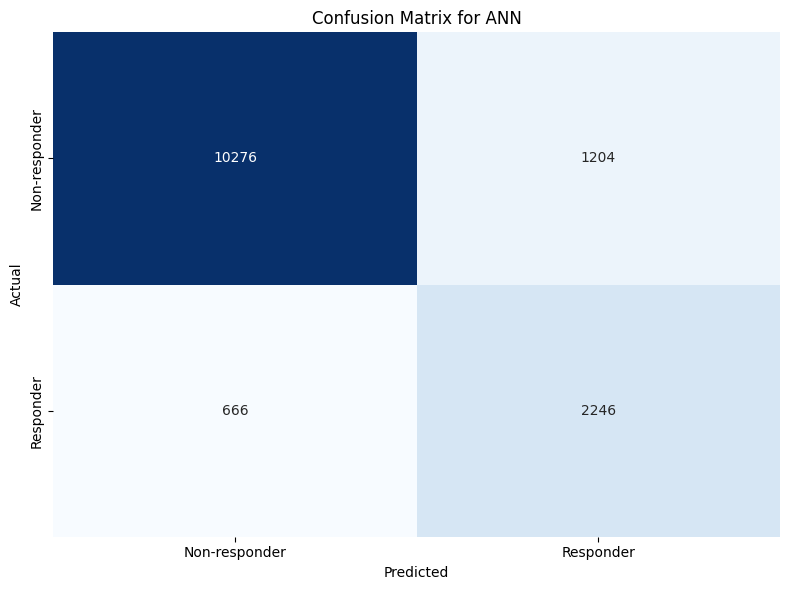

In [23]:
# 5. Predictions
y_train_pred_prob = ann_model.predict(X_train_scaled).flatten()
y_test_pred_prob = ann_model.predict(X_test_scaled).flatten()

# Use default 0.5 threshold for binary classification
y_train_pred_classes = (y_train_pred_prob > 0.5).astype(int)
y_test_pred_classes = (y_test_pred_prob > 0.5).astype(int)

# 6. Calculate metrics for Responder class (label=1)
train_acc = accuracy_score(y_train, y_train_pred_classes)
test_acc = accuracy_score(y_test, y_test_pred_classes)
precision = precision_score(y_test, y_test_pred_classes, pos_label=1)
recall = recall_score(y_test, y_test_pred_classes, pos_label=1)
f1 = f1_score(y_test, y_test_pred_classes, pos_label=1)
roc_auc = roc_auc_score(y_test, y_test_pred_prob)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {test_acc*100:.2f}")
print(f"Precision    : {precision*100:.2f}")
print(f"Recall       : {recall*100:.2f}")
print(f"F1 Score     : {f1*100:.2f}")
print(f"ROC AUC Score: {roc_auc*100:.2f}\n")

print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_classes, target_names=['Non-responder', 'Responder']))

# 7. Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title("Confusion Matrix for ANN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


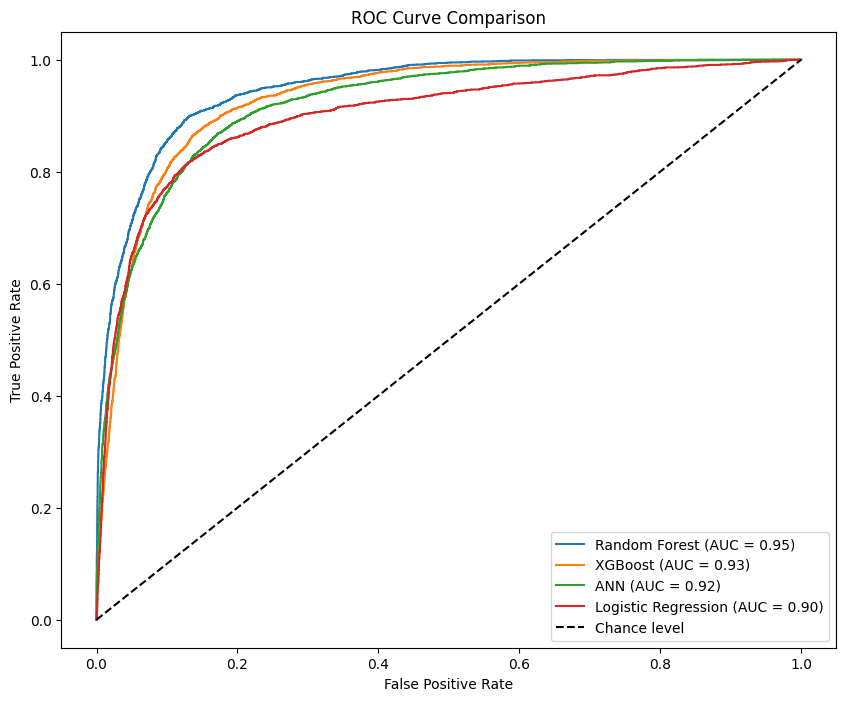

In [24]:
# --- Get prediction probabilities from each model ---
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]          # Random Forest (best model from GridSearchCV)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]        # XGBoost (best model from GridSearchCV)
y_prob_ann = ann_model.predict(X_test_scaled).ravel()    # ANN uses scaled test set
y_prob_lr = logreg.predict_proba(X_test)[:, 1]           # Logistic Regression pipeline

# --- Compute ROC curve and AUC for each model ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
auc_ann = auc(fpr_ann, tpr_ann)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# --- Plot ROC curves together ---
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {auc_ann:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance level')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

# **Calibration plots**

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


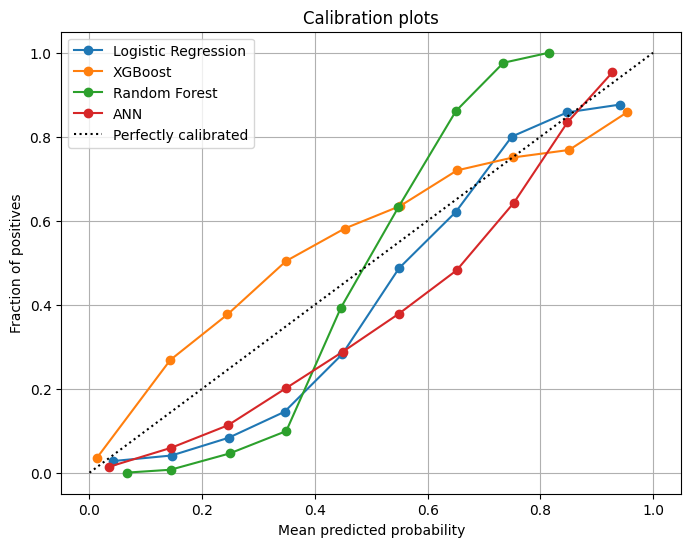

In [25]:
# --- Get prediction probabilities from trained models ---
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]           # Random Forest (best model from GridSearchCV)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]         # XGBoost (best model from GridSearchCV)
y_prob_ann = ann_model.predict(X_test_scaled).ravel()     # ANN uses scaled test set
y_prob_lr = logreg.predict_proba(X_test)[:, 1]            # Logistic Regression pipeline

# --- Plot calibration curves ---
plt.figure(figsize=(8, 6))

for model_name, y_prob in [
    ('Logistic Regression', y_prob_lr),
    ('XGBoost', y_prob_xgb),
    ('Random Forest', y_prob_rf),
    ('ANN', y_prob_ann)
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)

plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots')
plt.legend()
plt.grid(True)
plt.show()

# **Brier Scores**

In [26]:
# --- Compute Brier scores for each model ---
brier_lr = brier_score_loss(y_test, y_prob_lr)          # Logistic Regression
brier_xgb = brier_score_loss(y_test, y_prob_xgb)        # XGBoost
brier_rf = brier_score_loss(y_test, y_prob_rf)          # Random Forest
brier_ann = brier_score_loss(y_test, y_prob_ann)        # ANN

# --- Print Brier scores ---
print(f"Brier Score - Logistic Regression: {brier_lr:.4f}")
print(f"Brier Score - XGBoost: {brier_xgb:.4f}")
print(f"Brier Score - Random Forest: {brier_rf:.4f}")
print(f"Brier Score - ANN: {brier_ann:.4f}")

Brier Score - Logistic Regression: 0.0949
Brier Score - XGBoost: 0.0848
Brier Score - Random Forest: 0.0955
Brier Score - ANN: 0.0919


# **MCC**

In [27]:
threshold = 0.5  # You can adjust if needed

# --- Predicted classes for each model using the threshold ---
y_pred_lr = (y_prob_lr > threshold).astype(int)
y_pred_xgb = (y_prob_xgb > threshold).astype(int)
y_pred_rf = (y_prob_rf > threshold).astype(int)
y_pred_ann = y_test_pred_classes  # Already computed with default 0.5 threshold

# --- Compute Matthews Correlation Coefficient ---
mcc_lr = matthews_corrcoef(y_test, y_pred_lr)
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)
mcc_ann = matthews_corrcoef(y_test, y_pred_ann)

# --- Print MCC for all models ---
print(f"MCC - Logistic Regression: {mcc_lr:.4f}")
print(f"MCC - XGBoost: {mcc_xgb:.4f}")
print(f"MCC - Random Forest: {mcc_rf:.4f}")
print(f"MCC - ANN: {mcc_ann:.4f}")

MCC - Logistic Regression: 0.6494
MCC - XGBoost: 0.6182
MCC - Random Forest: 0.6788
MCC - ANN: 0.6271


# **SHAP**

/tmp/ipython-input-1965190265.py:25: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_top, X_test_top, feature_names=feature_names_top, plot_type="bar")


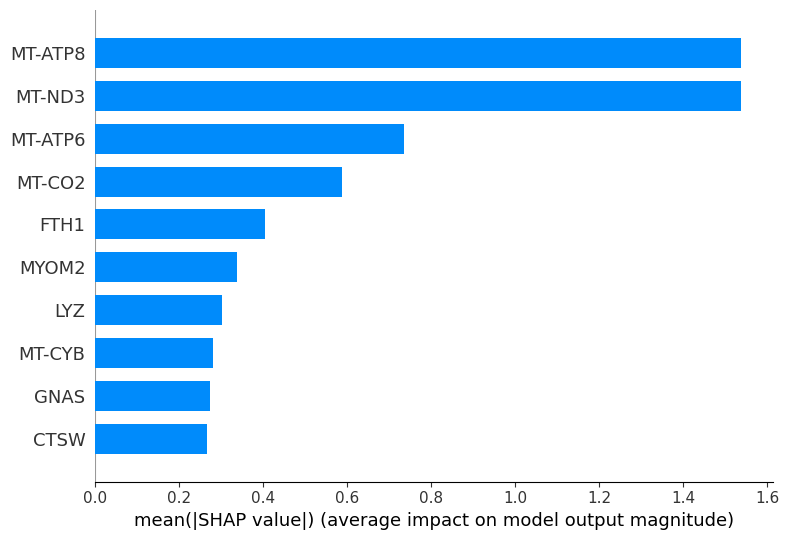

/tmp/ipython-input-1965190265.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_top, X_test_top, feature_names=feature_names_top)


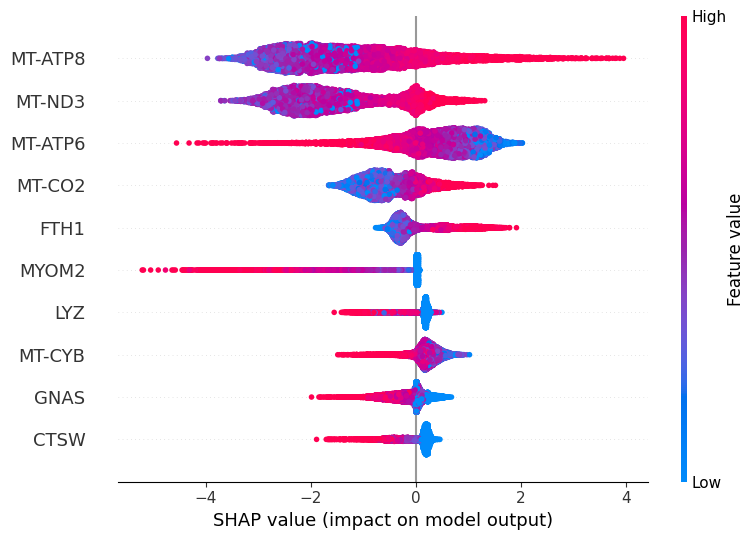

In [28]:
# Step 1: Get the feature names
feature_names = X_train.columns

# Step 2: Extract the fitted XGB model from the pipeline
fitted_xgb = best_xgb.named_steps['model']

# Step 3: Create SHAP explainer
explainer = shap.TreeExplainer(fitted_xgb)

# Step 4: Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Step 5: Compute mean absolute SHAP values across samples
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Step 6: Get indices of top 10 features
top_idx = np.argsort(mean_abs_shap)[-10:]

# Step 7: Restrict to top 10 features
X_test_top = X_test.iloc[:, top_idx]
shap_values_top = shap_values[:, top_idx]

# Step 7b: Add prefix based on feature type
feature_names_top = []
for name in X_test_top.columns:
    if name.endswith("_L") or name.endswith("_t"):
        feature_names_top.append("F_" + name)  # Fluxomic feature
    else:
        feature_names_top.append("G_" + name)  # Gene feature

# Step 8: Plot summary (bar + beeswarm) for top 10 features
shap.summary_plot(shap_values_top, X_test_top, feature_names=feature_names_top, plot_type="bar")
shap.summary_plot(shap_values_top, X_test_top, feature_names=feature_names_top)

/tmp/ipython-input-13159540.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_last, X_test_last, feature_names=feature_names_last, plot_type="bar")


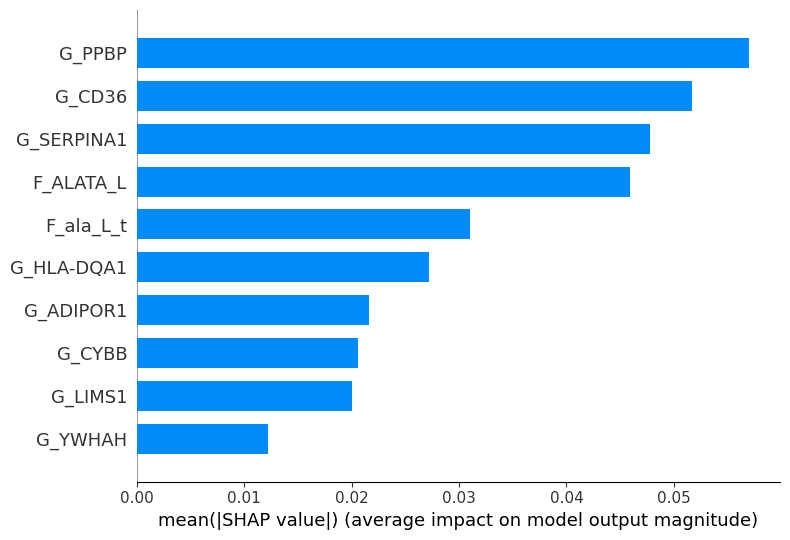

/tmp/ipython-input-13159540.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_last, X_test_last, feature_names=feature_names_last)


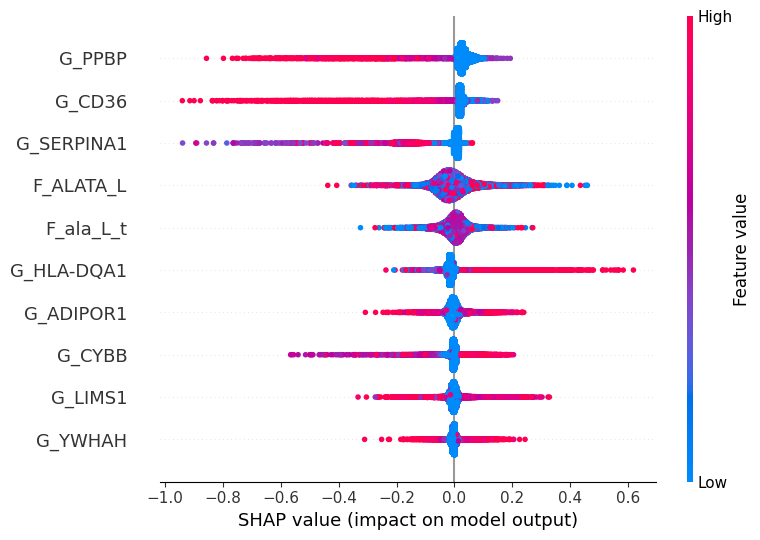

In [33]:
# Step 1: Get the feature names
feature_names = X_train.columns

# Step 2: Extract the fitted XGB model from the pipeline
fitted_xgb = best_xgb.named_steps['model']

# Step 3: Create SHAP explainer
explainer = shap.TreeExplainer(fitted_xgb)

# Step 4: Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Step 5: Select the last 10 feature indices
last_idx = np.arange(len(feature_names) - 10, len(feature_names))

# Step 6: Restrict to last 10 features
X_test_last = X_test.iloc[:, last_idx]
shap_values_last = shap_values[:, last_idx]

# Step 7: Add prefix based on feature type
feature_names_last = []
for name in X_test_last.columns:
    if name.endswith("_L") or name.endswith("_t"):
        feature_names_last.append("F_" + name)  # Fluxomic features
    else:
        feature_names_last.append("G_" + name)  # Gene features

# Step 8: Plot summary (bar + beeswarm) for last 10 features
shap.summary_plot(shap_values_last, X_test_last, feature_names=feature_names_last, plot_type="bar")
shap.summary_plot(shap_values_last, X_test_last, feature_names=feature_names_last)

In [34]:
# Step 1: Get the feature names
feature_names = X_train.columns

# Step 2: Extract the fitted XGB model from the pipeline
fitted_xgb = best_xgb.named_steps['model']

# Step 3: Create SHAP explainer
explainer = shap.TreeExplainer(fitted_xgb)

# Step 4: Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Step 5: Compute mean absolute SHAP values across samples
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Step 6: Print all features with their mean absolute SHAP values and type prefix
print("Feature | Mean Absolute SHAP")
print("-" * 40)
for i in range(len(feature_names)):
    name = feature_names[i]
    if name.endswith("_L") or name.endswith("_t"):
        prefix = "F_"  # Fluxomic feature
    else:
        prefix = "G_"  # Gene feature
    print(f"{prefix}{name}: {mean_abs_shap[i]:.6f}")

Feature | Mean Absolute SHAP
----------------------------------------
G_MT-ATP8: 1.536472
G_MT-ND3: 1.536469
G_MT-ND4L: 0.164412
G_MT-CO2: 0.586769
G_MT-ATP6: 0.734624
G_MT-CYB: 0.280929
G_LYZ: 0.300963
G_GNAS: 0.273251
G_MT-ND1: 0.255833
G_FTH1: 0.403973
G_S100A9: 0.166481
G_MT-ND5: 0.107735
G_S100A8: 0.169400
G_TMEM176B: 0.168782
G_FTL: 0.091387
G_CD74: 0.106215
G_ZFP36: 0.161041
G_TGFB1: 0.204130
G_SH3BGRL3: 0.188534
G_S100A6: 0.102210
G_NEAT1: 0.085746
G_PSAP: 0.049246
G_TLN1: 0.043122
G_OST4: 0.079747
G_HBB: 0.103342
G_DUSP2: 0.156795
G_CD151: 0.115725
G_HLA-DPB1: 0.129911
G_COTL1: 0.056964
G_CTSW: 0.265954
G_IFI30: 0.085400
G_S100A11: 0.060057
G_RAP1B: 0.047179
G_CALM3: 0.052005
G_RGS10: 0.049197
G_HLA-DPA1: 0.073684
G_TNFAIP3: 0.063595
G_HLA-DQB1: 0.218358
G_CTSS: 0.035661
G_SAT1: 0.055645
G_MT2A: 0.046122
G_KIF2A: 0.042590
G_HLA-DRA: 0.033752
G_FCER1G: 0.079896
G_ENSG00000269028: 0.104785
G_ABO: 0.030106
G_MAX: 0.067983
G_AIF1: 0.084643
G_HLA-DRB1: 0.076252
G_TUBA1B: 0.075969
G